### Compound feature analysis
Compound feature space exploration using PCA, kernel PCA and KMeans. Compounds are explored from physicochemical and structural perspectives (e.g., using fingerprints).

This analysis is one of the key elements of a more comprehensive EDA which helps to understand the chemical space that is being explored. Based on the data, one then can start building further analysis and ML strategies.

Please note this is a simplified example for exploration purposes.

In [1]:
#Import libraries
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,PandasTools, Descriptors, Draw

from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.cluster import KMeans

In [29]:
#Import data

#We are going to use CHEMBL small molecule phase 3 and 4 data

data=pd.read_table("./Data/chembl_3_4.tsv")
#Drop data that has missing Smiles
data=data.dropna(subset=['Smiles','Bioactivities'])
target=data['Bioactivities'] #Set an arbitrary target in this case compound bioactivity
data.reset_index(inplace=True)
print(data.head())
print("Number of molecules",len(data))

   index      ChEMBL ID                Name  \
0      0   CHEMBL590799            CAMOSTAT   
1      1  CHEMBL1200675  TOREMIFENE CITRATE   
2      2   CHEMBL258405             ICILLIN   
3      4  CHEMBL1200436         OXANDROLONE   
4      5   CHEMBL506871           VELIPARIB   

                                            Synonyms            Type  \
0                                           CAMOSTAT  Small molecule   
1    FC-1157A|Fareston|NSC-613680|TOREMIFENE CITRATE  Small molecule   
2                                     ICILLIN|Icilin  Small molecule   
3  ANAVAR|LONAVAR|NSC-67068|OXANDROLONE|OXANDROLO...  Small molecule   
4         ABT-888|PARP-1 INHIBITOR ABT-888|VELIPARIB  Small molecule   

   Max Phase  Molecular Weight  Targets  Bioactivities AlogP  ...  \
0          3            398.42     28.0           62.0  1.39  ...   
1          4            598.09     80.0          115.0  6.22  ...   
2          3            311.30     30.0           57.0  2.87  ...   
3       

In [30]:
#Prepare data
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='Smiles',molCol='RMol')
data=data[['ChEMBL ID', 'Name','Smiles','RMol']]
#Add hidrogens to MOL for future analyses
data['RMolH']=data.RMol.apply(lambda x: Chem.AddHs(x))

In [31]:
#Transform bioactivities into categories to make predictions (this can be done as a first step to better understand the data)
#In this case, we are going to use categories to make analysis more representative since we are not working
#with a specialised HTS dataset.
#This step might not be necessary if you have categorical grouping
print(target.describe())
target_vals=pd.qcut(target,q=[0,0.25,0.5,0.75,0.9,1],labels=['very low',"low","medium",'high','very high'])

target_vals=pd.DataFrame(target_vals)
target_vals.index=list(range(len(target_vals)))
target_vals

count     3643.000000
mean       378.031567
std        898.247031
min          1.000000
25%         17.000000
50%         58.000000
75%        312.500000
max      17911.000000
Name: Bioactivities, dtype: float64


Bioactivities
0           medium
1           medium
2              low
3              low
4             high
...            ...
3638      very low
3639      very low
3640      very low
3641      very low
3642      very low

[3643 rows x 1 columns]

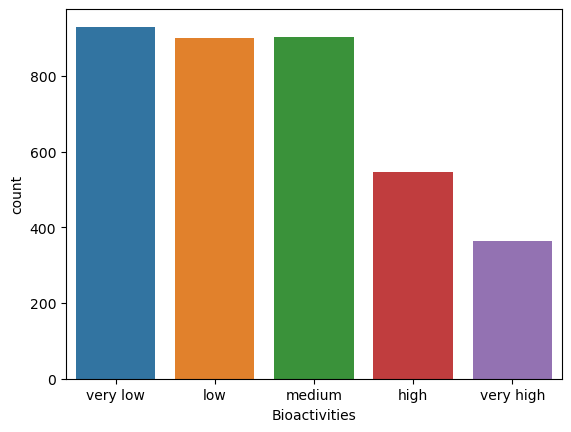

In [6]:
sns.countplot(data=target_vals,x='Bioactivities')
plt.show()
#We can see that the data distribution is not exactly uniform and the dataset is not very balanced.
#This might require addressing during model building; however, for exploratory analysis this is not necessary as our goal is to capture feature relationships and dependencies.
#We might return to this step to set bioactivity classes differently in order to better model the data.

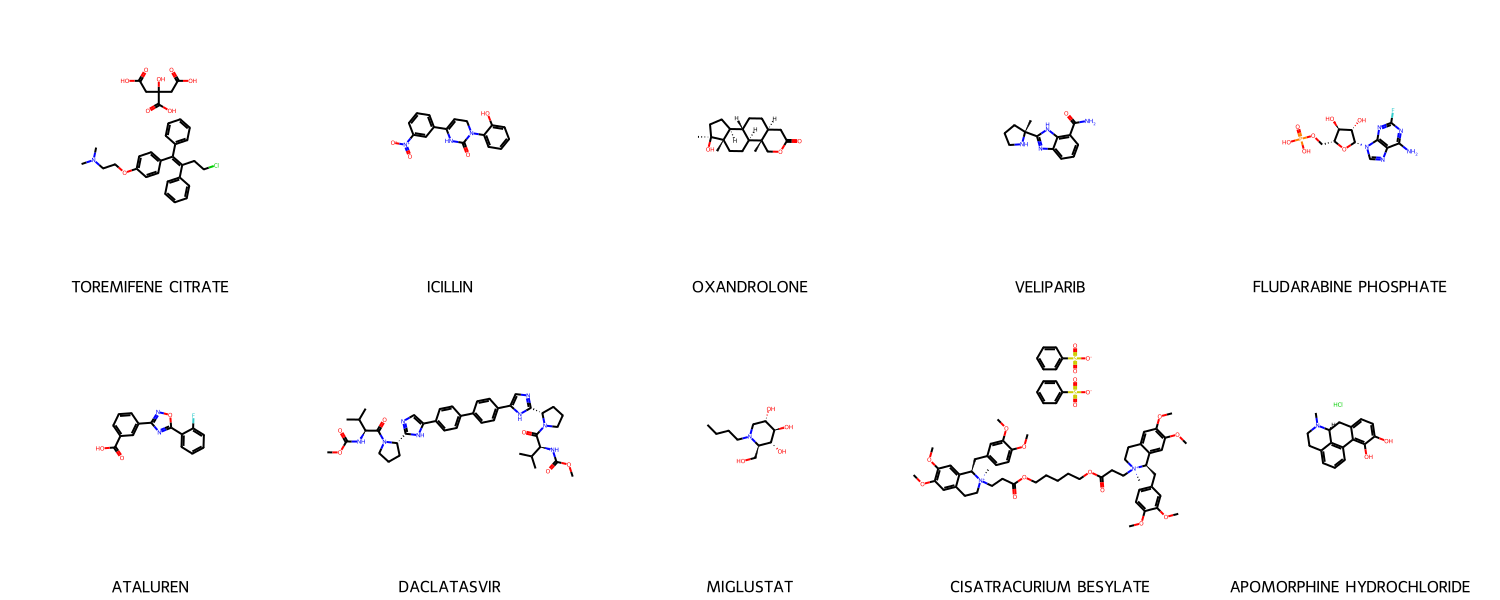

In [12]:
#Visualise molecules

Draw.MolsToGridImage(data['RMol'][1:11],molsPerRow=5,legends=list(data['Name'][1:11]),subImgSize=(300,300))

In [32]:
#Add molecular descriptors

data["MW"]=data.RMol.apply(lambda x: Descriptors.ExactMolWt(x))
data["TPSA"]=data.RMol.apply(lambda x: Chem.rdMolDescriptors.CalcTPSA(x))
data["AromaticRings"]=data.RMol.apply(lambda x: Chem.rdMolDescriptors.CalcNumAromaticRings(x))
data["nRB"]=data.RMol.apply(lambda x: Descriptors.NumRotatableBonds(x))
data["HBA"]=data.RMol.apply(lambda x: Descriptors.NumHAcceptors(x))
data["HBD"]=data.RMol.apply(lambda x: Descriptors.NumHDonors(x))
data["LogP"]=data.RMol.apply(lambda x: Descriptors.MolLogP(x))


In [33]:
#Get data statistics
print(data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP']].describe())

#Using quantiles split data based on MW categories to visualise different compounds groups
#NOTE this is grouping serves as an example. 
#You would typically explore various groupings based on prior knowledge about your compounds and specific features and parameters you are exploring

data['MW_bins']=pd.qcut(data['MW'],q=[0,0.25,0.5,0.75,0.9,0.99,1],labels=['<275','<370','<480','>500','>750','>1200'])
#Add bins to data
print(data.head())


                MW         TPSA  AromaticRings          nRB          HBA  \
count  3643.000000  3643.000000    3643.000000  3643.000000  3643.000000   
mean    387.894553    91.410225       1.663464     5.525391     5.290694   
std     188.372698    71.611832       1.287097     4.543535     3.705568   
min       4.002603     0.000000       0.000000     0.000000     0.000000   
25%     273.082350    46.530000       1.000000     3.000000     3.000000   
50%     362.209324    77.760000       2.000000     5.000000     4.000000   
75%     464.658576   113.910000       2.000000     7.000000     7.000000   
max    1753.637429   896.660000      12.000000    59.000000    38.000000   

               HBD         LogP  
count  3643.000000  3643.000000  
mean      2.126819     2.206950  
std       2.406940     3.016665  
min       0.000000   -18.726900  
25%       1.000000     0.783050  
50%       2.000000     2.574200  
75%       3.000000     4.013150  
max      36.000000    17.853900  
       Ch

In [9]:
#Explore grouped data
print(data.MW_bins.value_counts())

<275     912
<370     910
<480     910
>500     546
>750     328
>1200     37
Name: MW_bins, dtype: int64


### Exploratory data analysis
This is part highlights a couple of ways to explore your data. Various plots can help to understand various dependencies, collinearities or emerging groups. It also aids with identifying outliers that should be addressed during the analysis.
Exploratory analyses typically consist of a well-curated set of methods that are applied to your data.

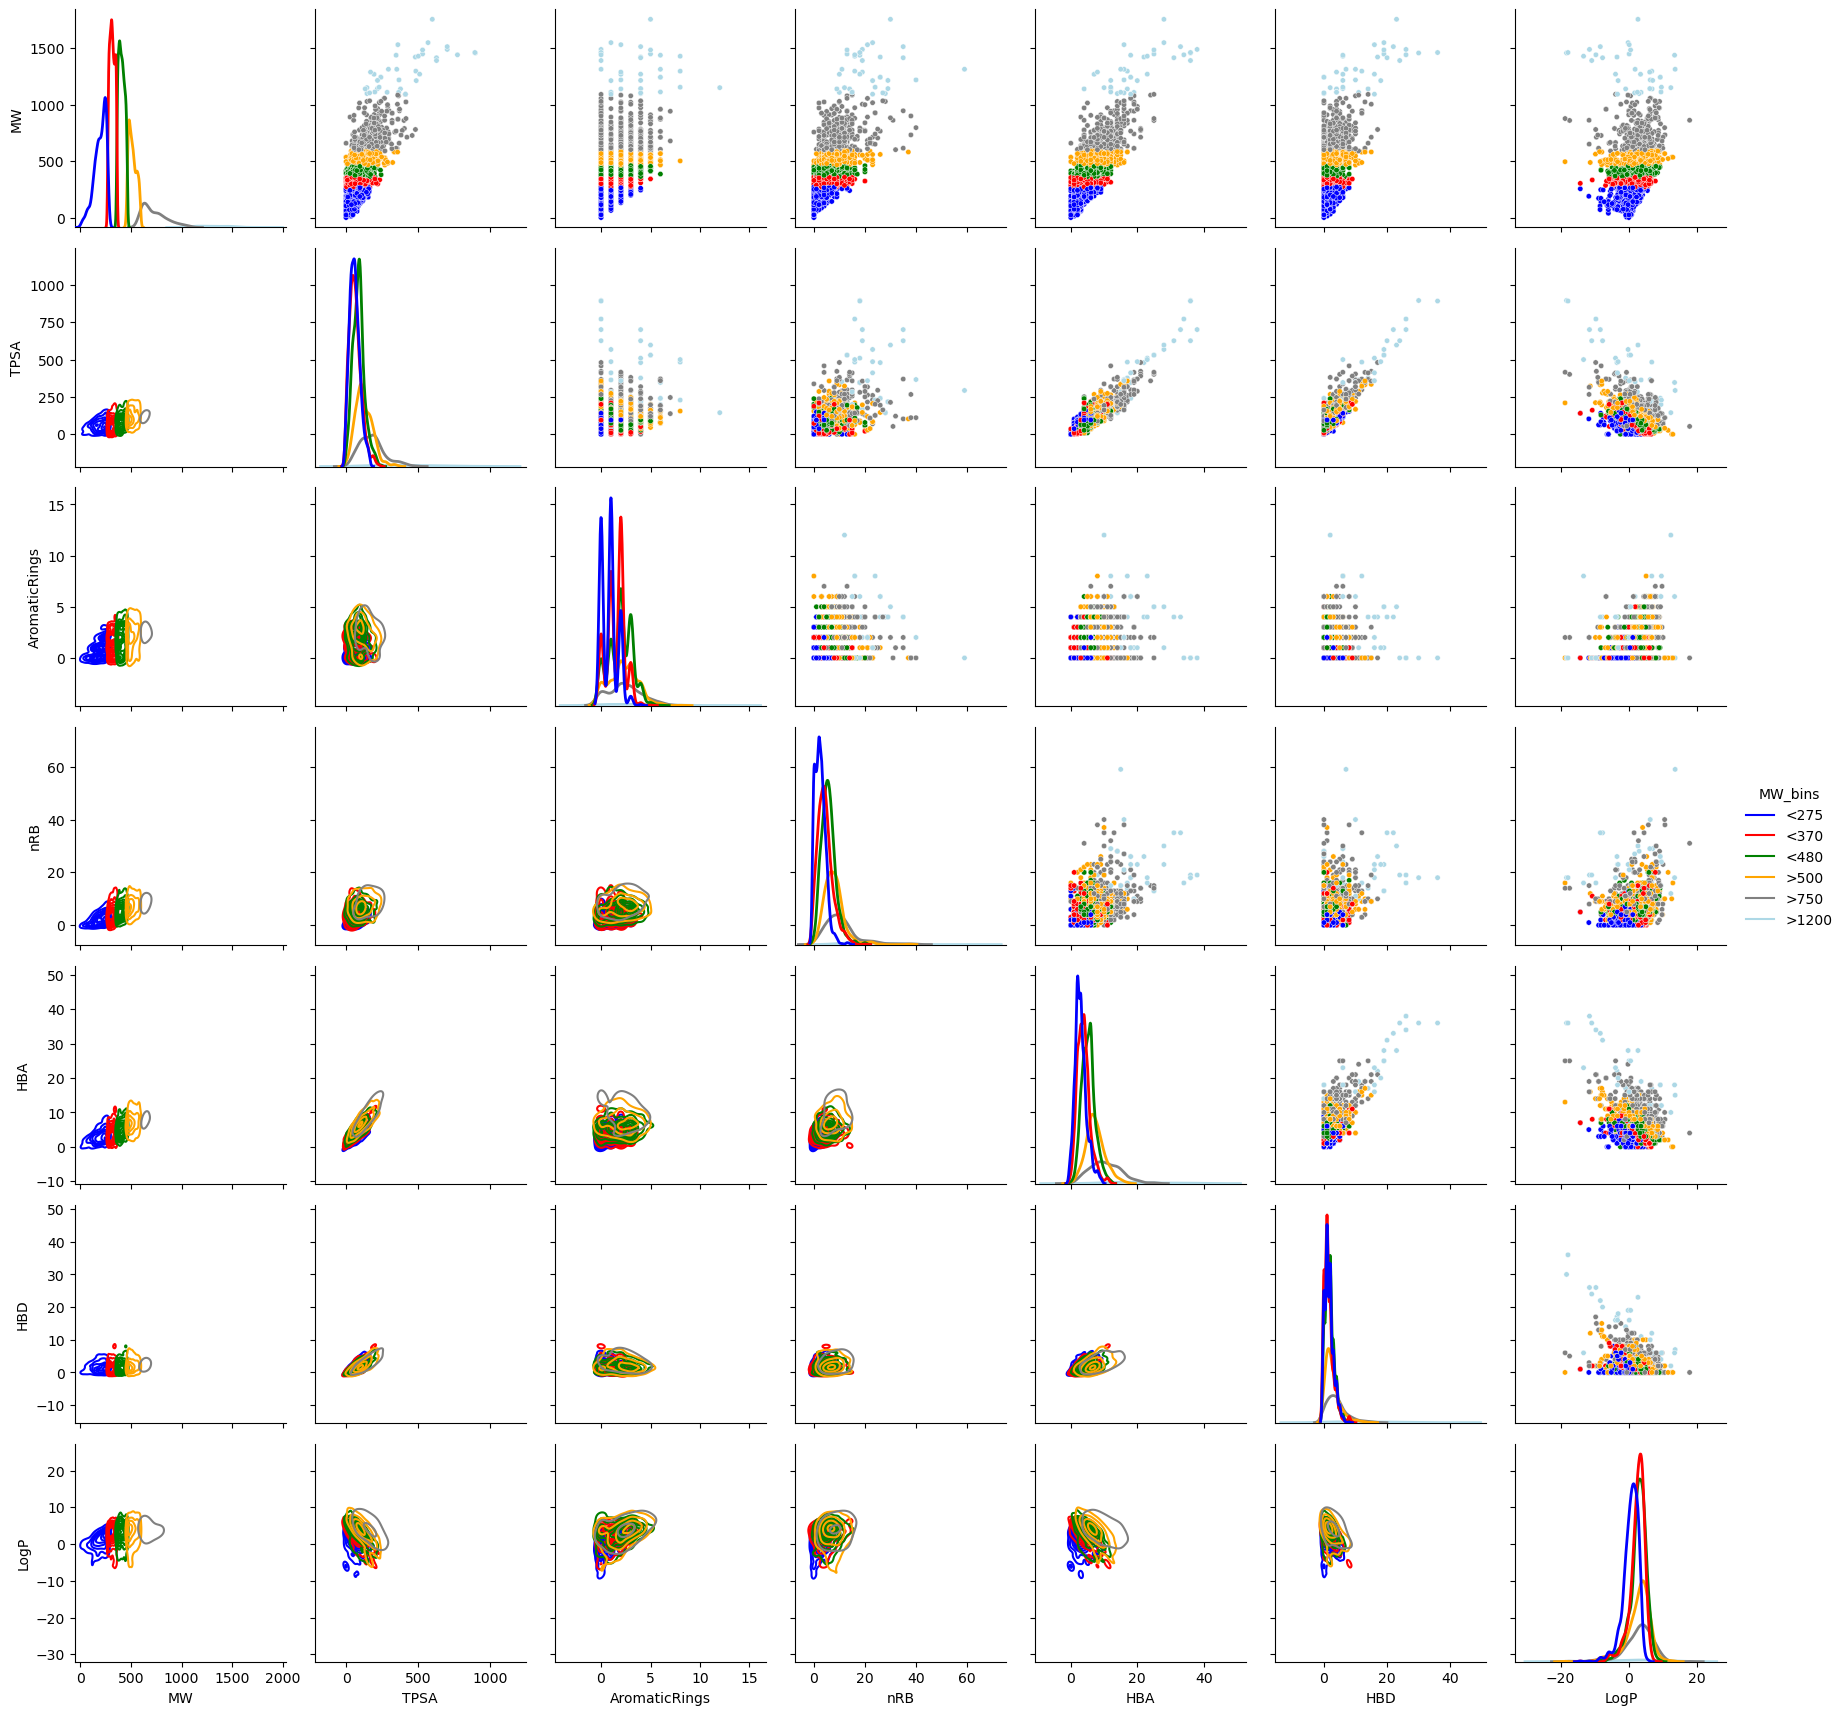

In [34]:
#Explore data pairwise distribution
p = sns.PairGrid(data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP','MW_bins']],hue='MW_bins', palette=['blue','red','green','orange','grey','lightblue'], diag_sharey=False)
p.map_upper(sns.scatterplot, s=15)
p.map_lower(sns.kdeplot)
p.map_diag(sns.kdeplot, lw=2)
p.add_legend()
plt.show()


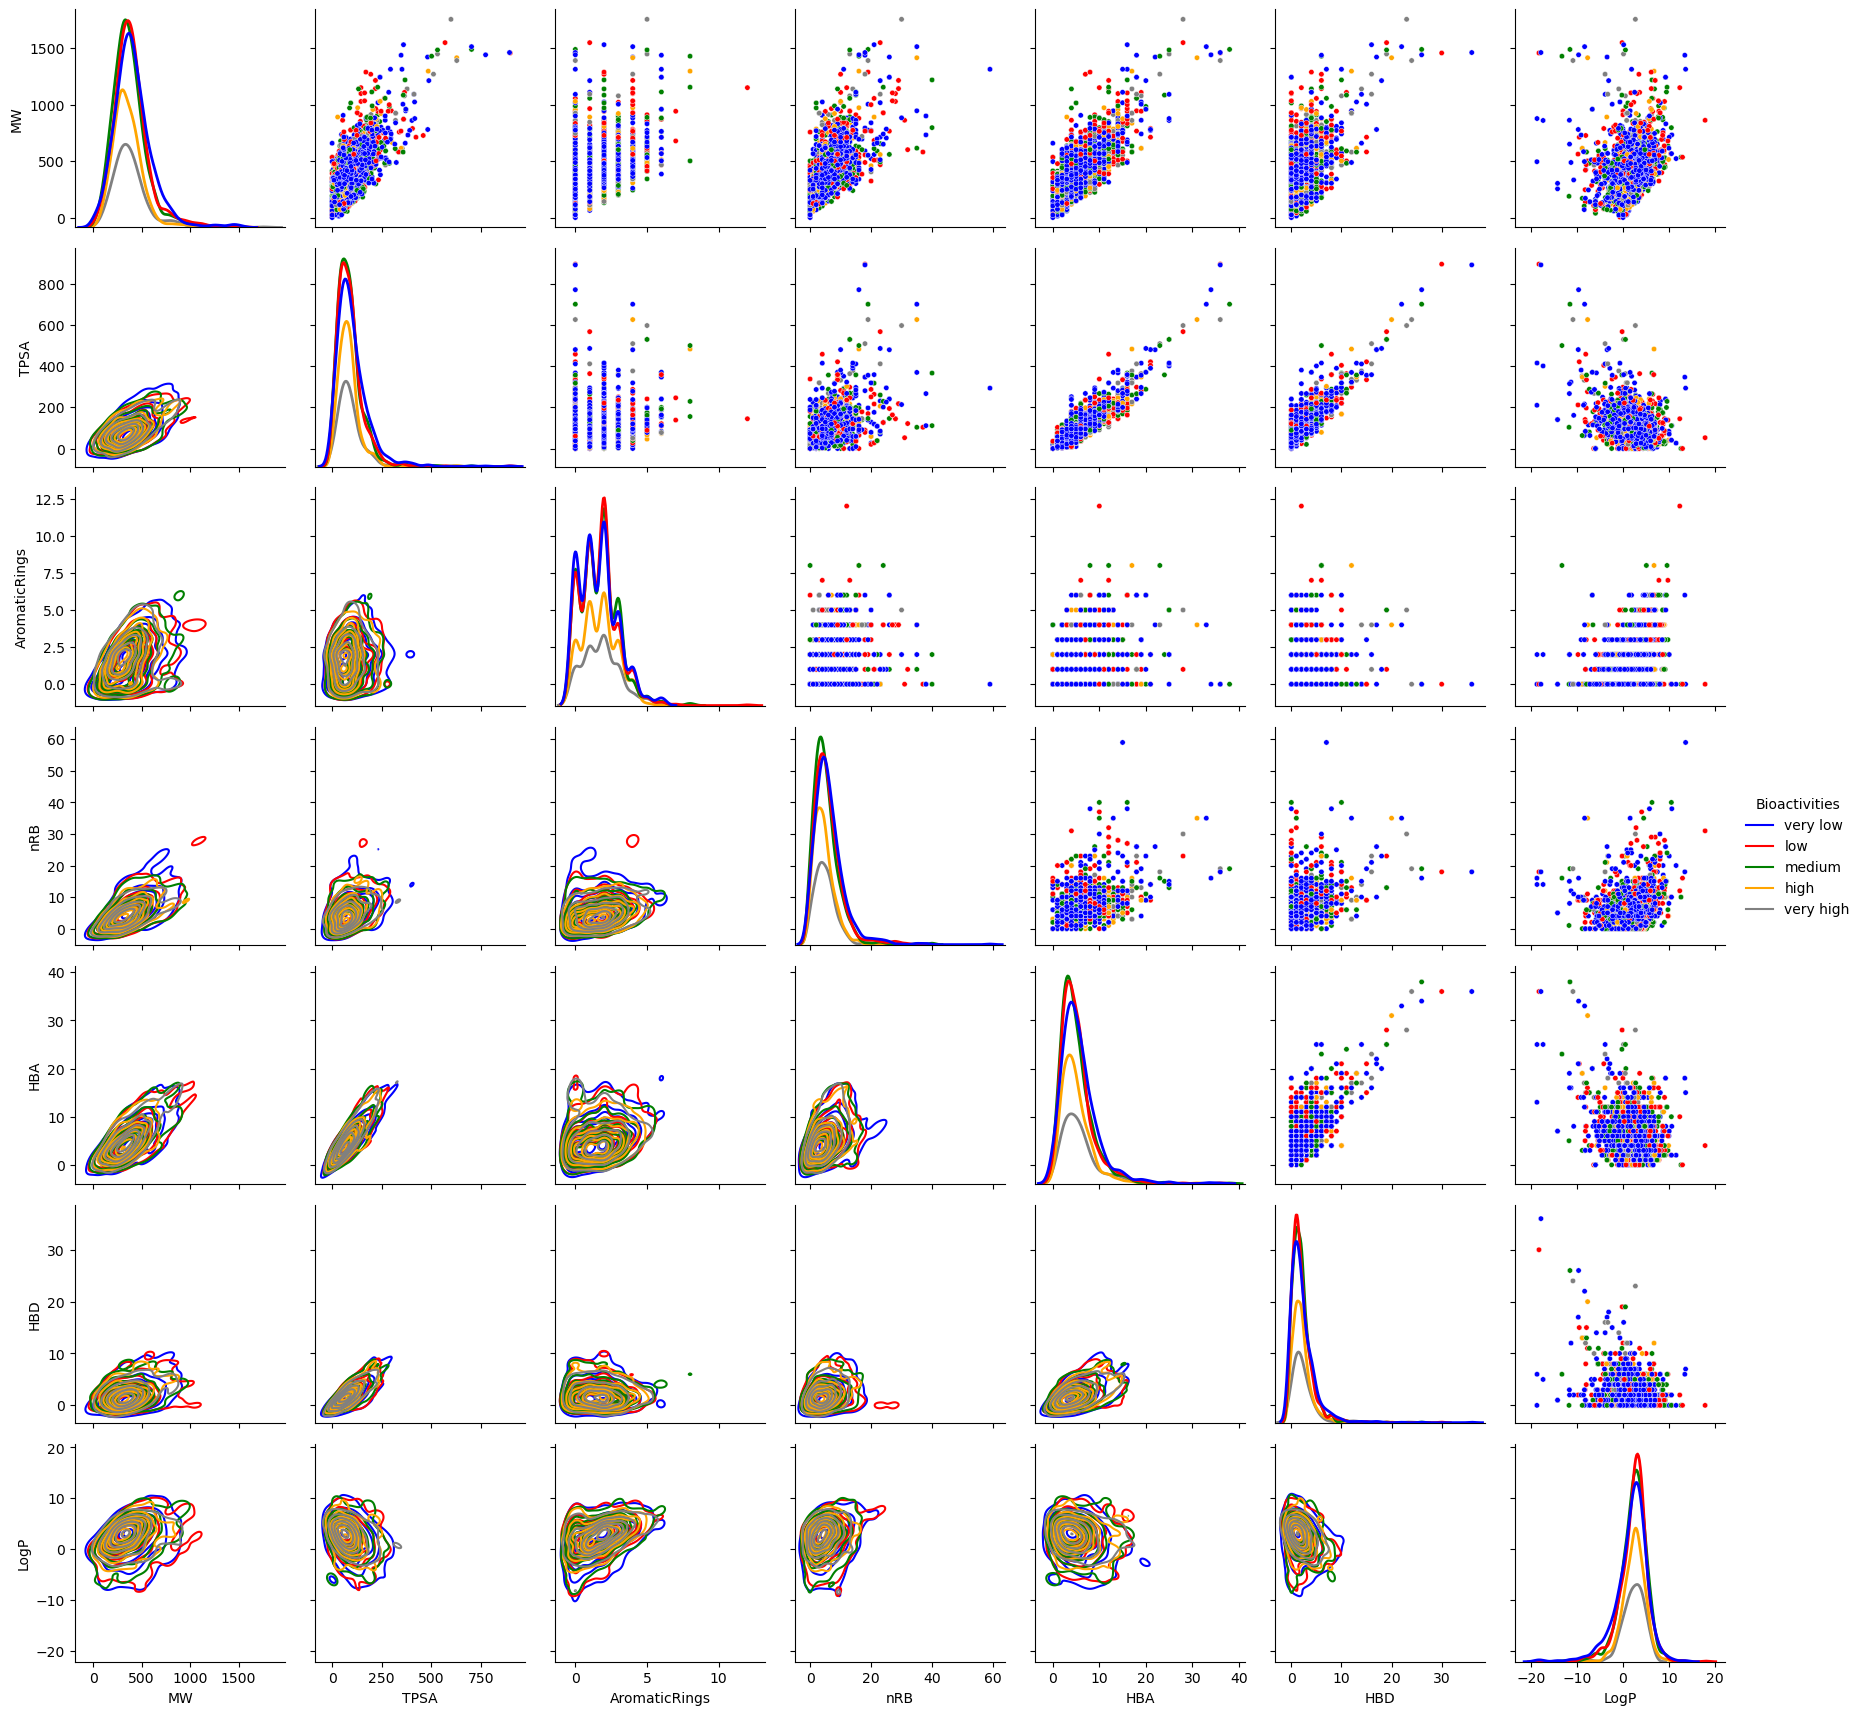

In [35]:
df=data.copy()
df['Bioactivities']=target_vals[['Bioactivities']]
p = sns.PairGrid(df[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP','MW_bins','Bioactivities']],hue='Bioactivities', palette=['blue','red','green','orange','grey','lightblue'], diag_sharey=False)
p.map_upper(sns.scatterplot, s=15)
p.map_lower(sns.kdeplot)
p.map_diag(sns.kdeplot, lw=2)
p.add_legend()
plt.show()

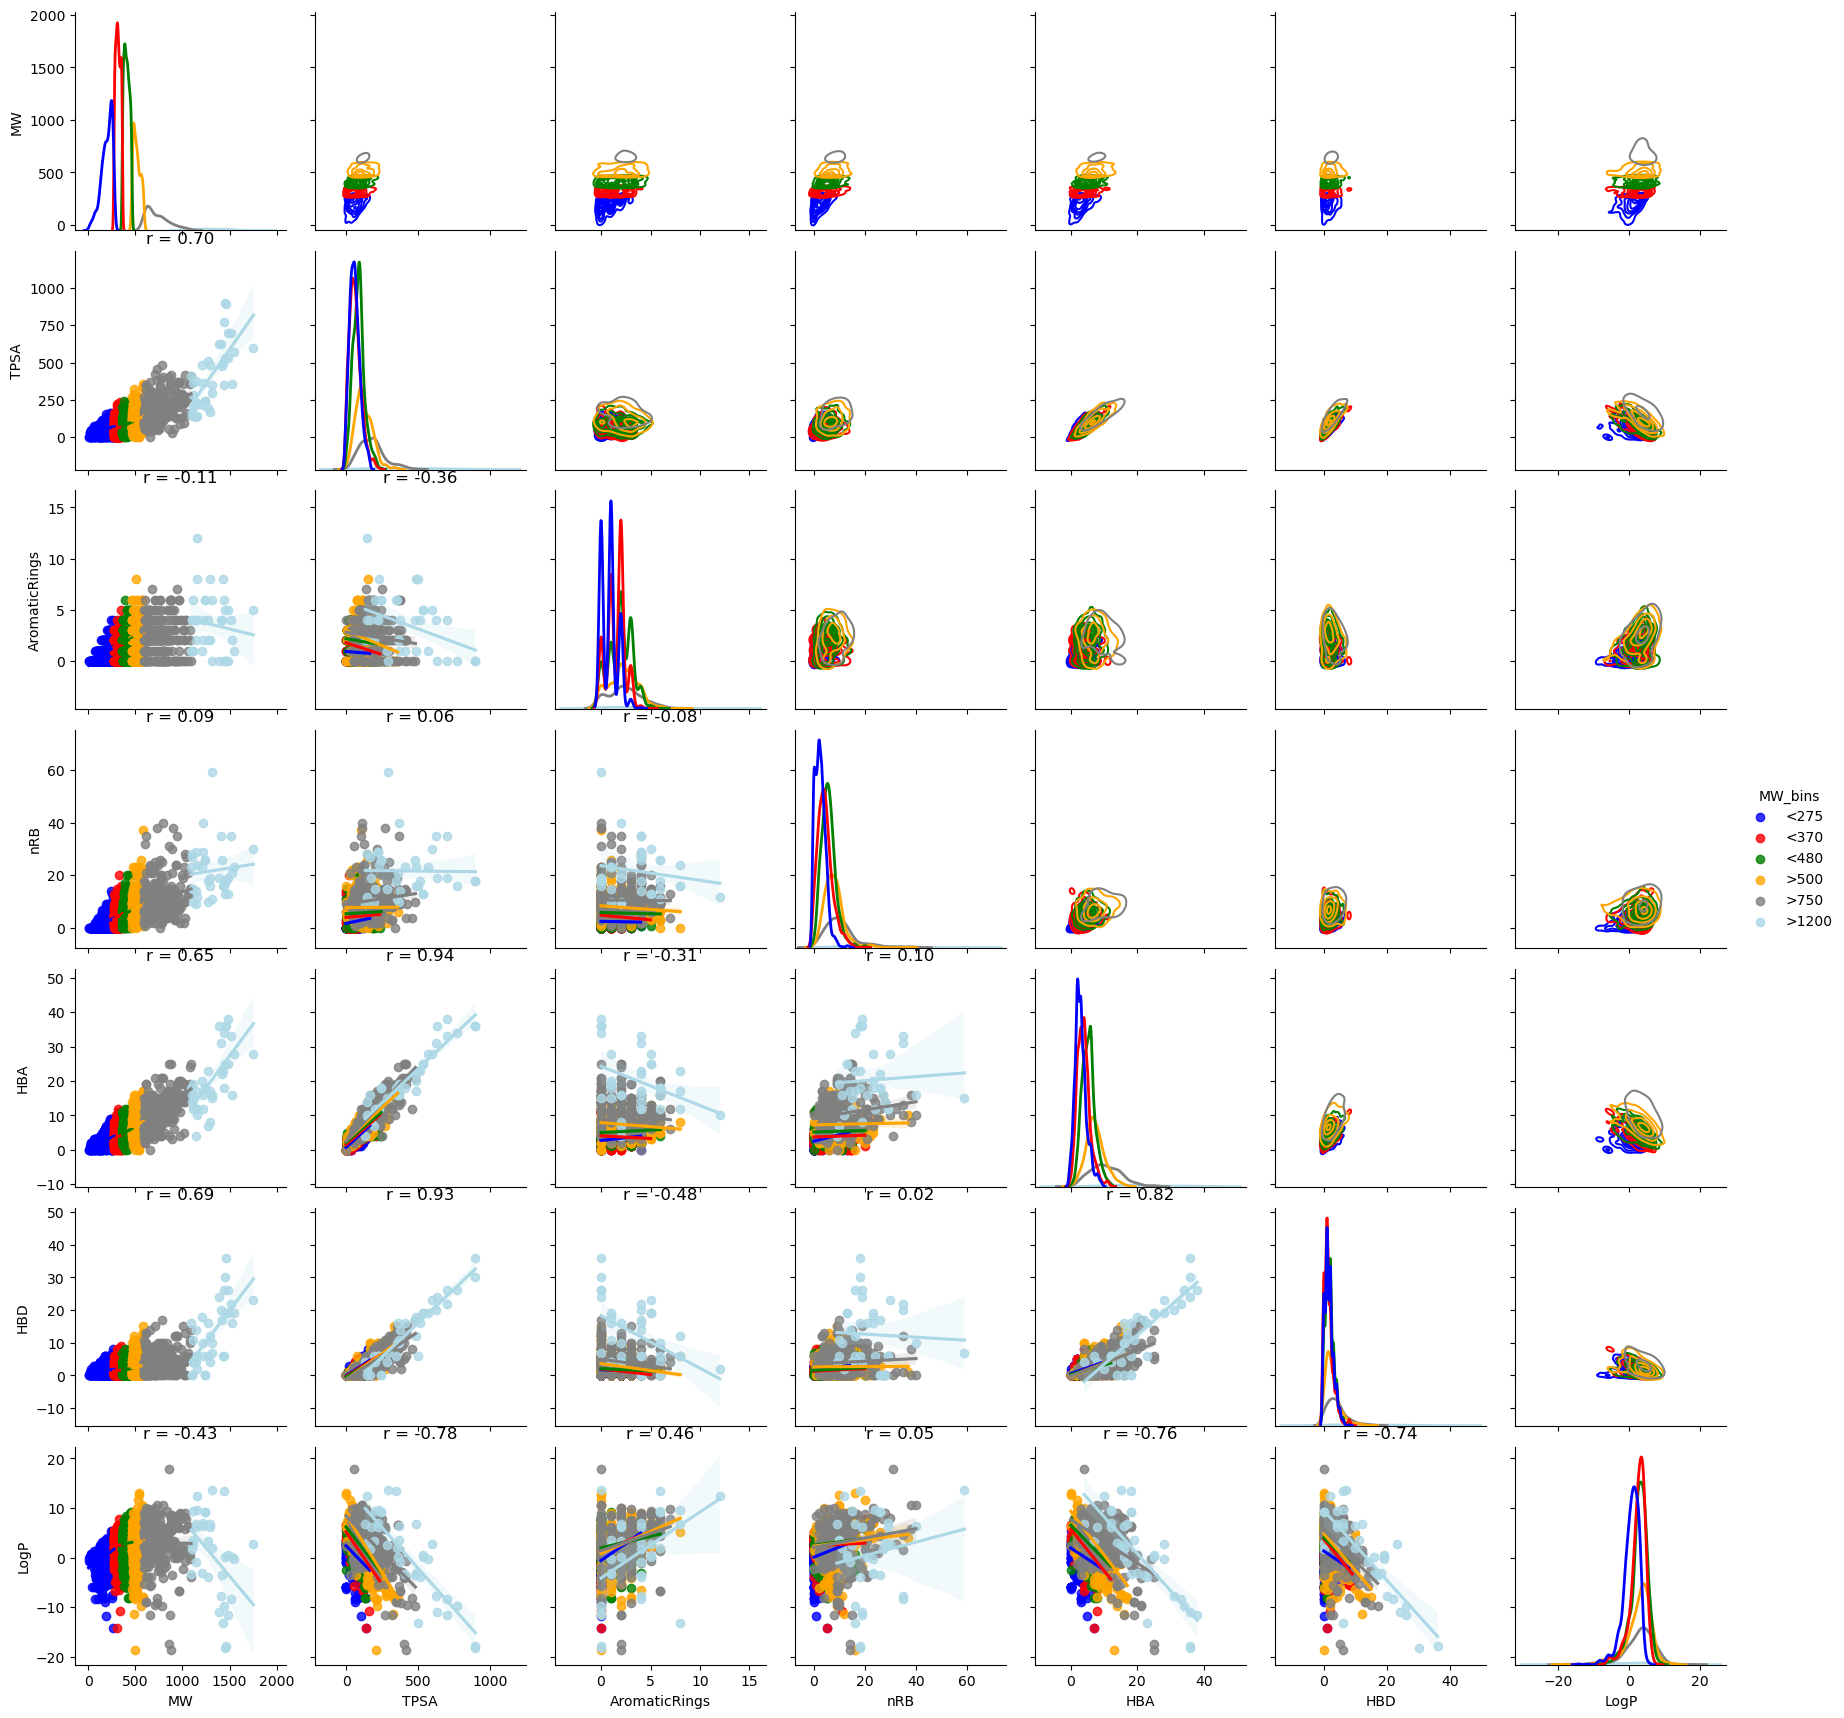

In [36]:
#Incorporate correlation coeficient
from scipy.stats import spearmanr
def corr(x,y,**kwargs):
    
    r,p=spearmanr(x,y)
    plt.title(f'r = {r:.2f}')
    
    return

p = sns.PairGrid(data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP','MW_bins']],hue='MW_bins', palette=['blue','red','green','orange','grey','lightblue'], diag_sharey=False)
p.map_lower(sns.regplot)
p.map_upper(sns.kdeplot)
p.map_diag(sns.kdeplot, lw=2)
p.map_lower(corr)
p.add_legend()
plt.show()

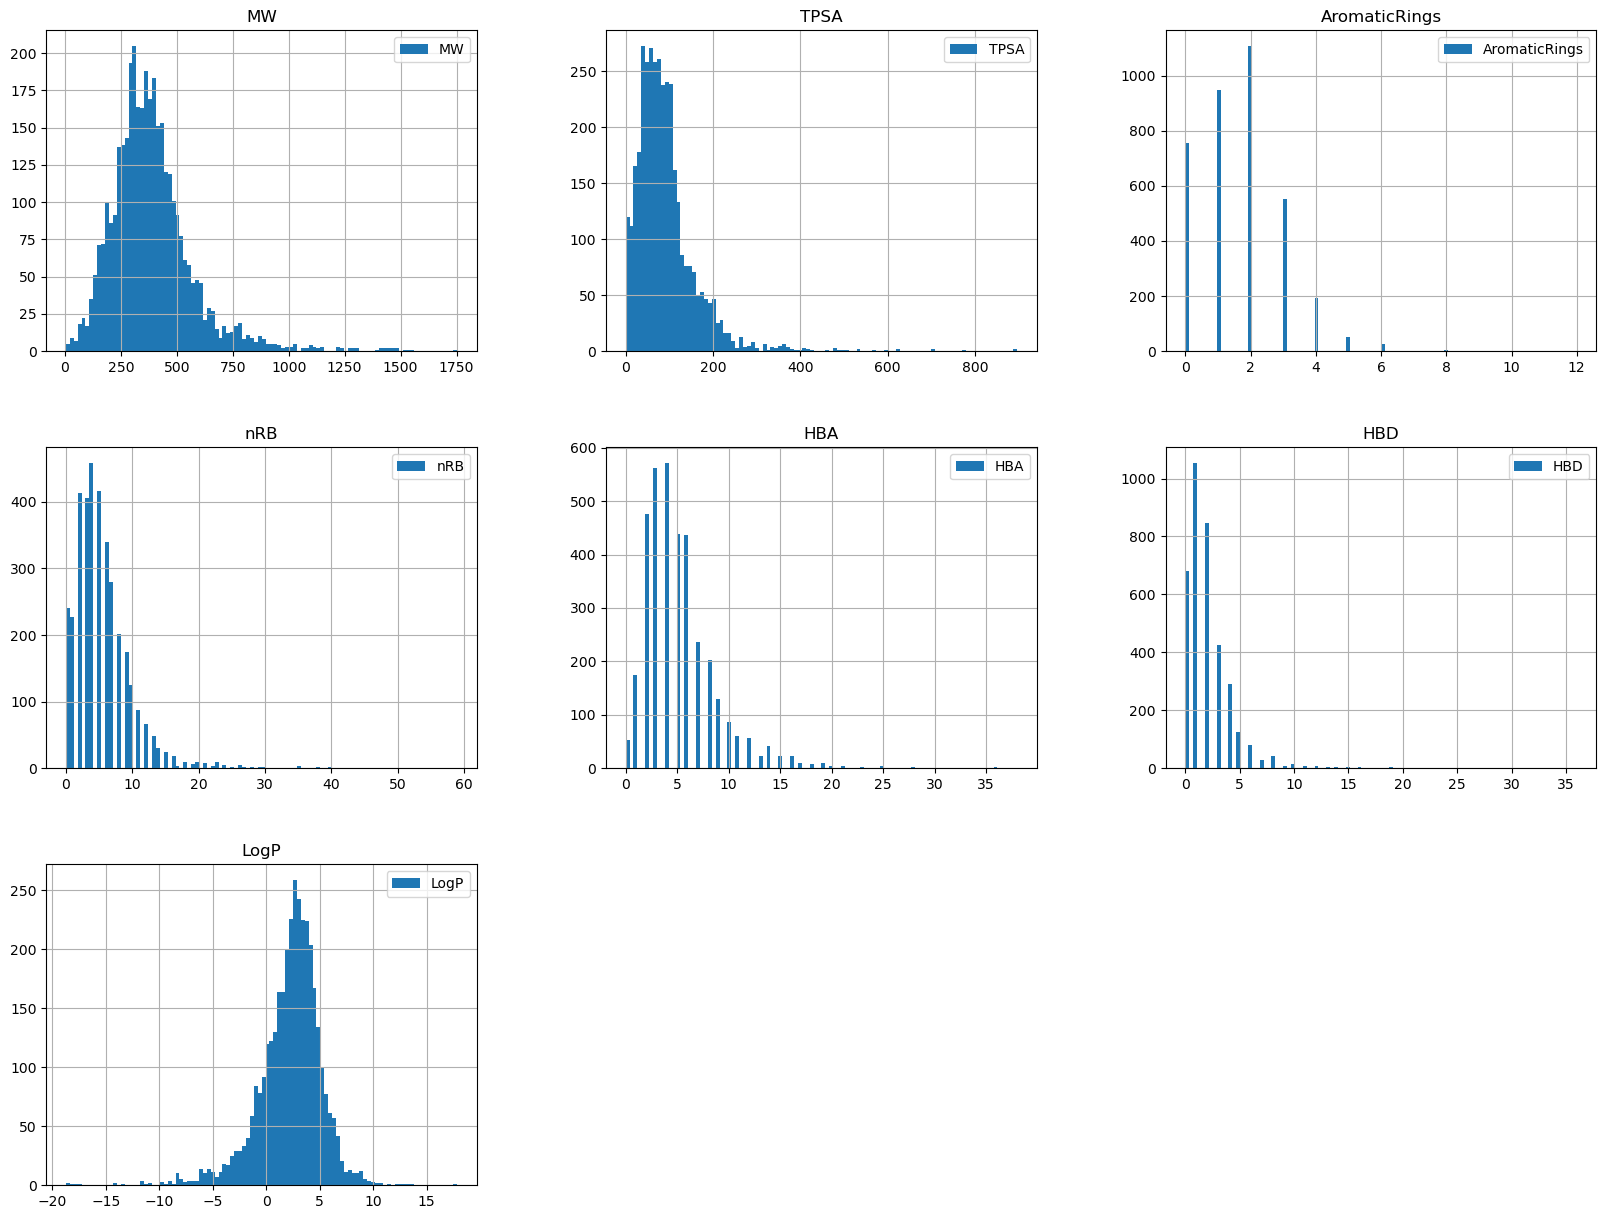

In [37]:
#In addition you can explore individual distributions to better understand how data points are distributed and capture potential outliers
data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP','MW_bins']].hist(bins=100,figsize=(20, 15), legend=True)
plt.show()

Specific features that might be relevant for the analysis should be assessed separately 

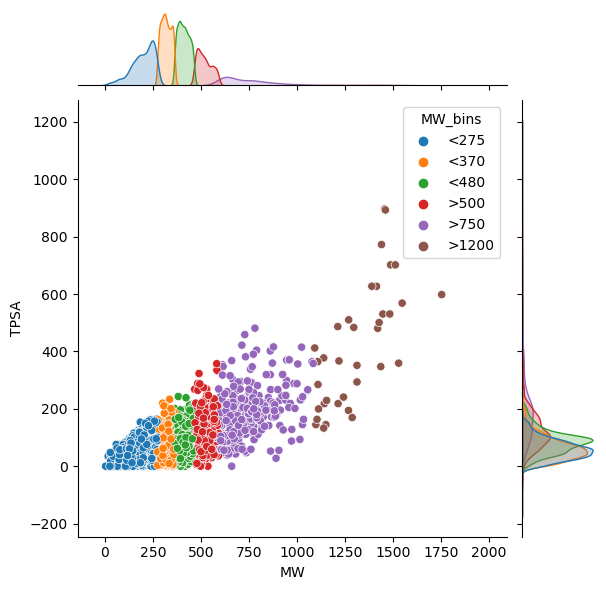

In [104]:
#Explore individual jointplots

sns.jointplot(x=data.MW,y=data.TPSA,kind='scatter',hue=data.MW_bins)
plt.show()

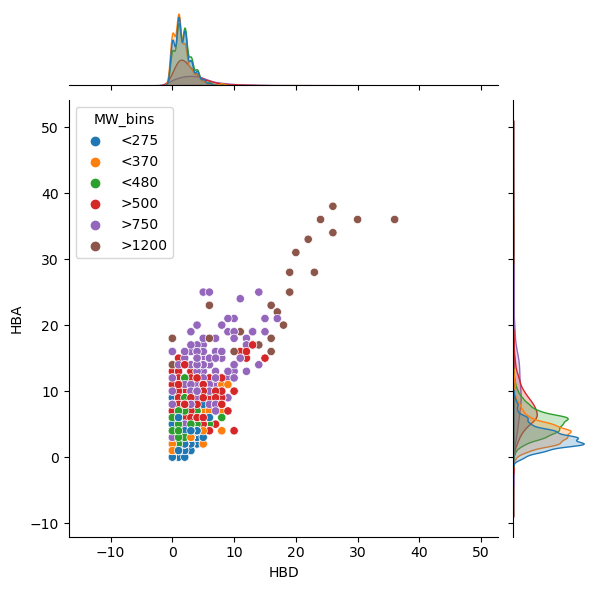

In [12]:
#Explore individual jointplots

sns.jointplot(x=data.HBD,y=data.HBA,kind='scatter',hue=data.MW_bins)
plt.show()

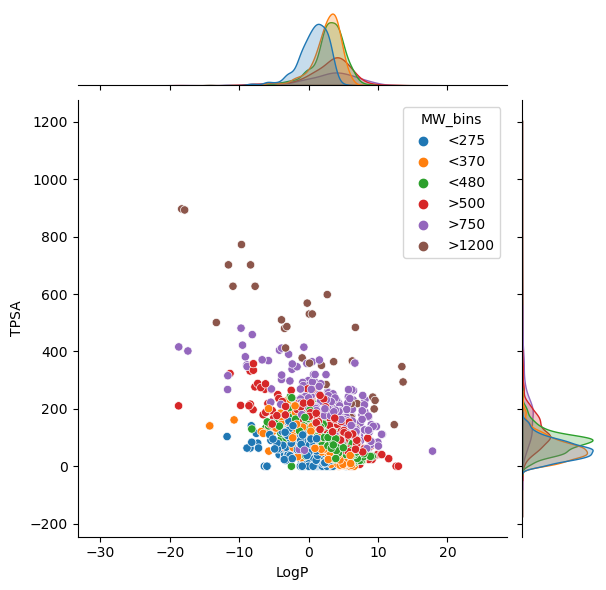

In [13]:
sns.jointplot(x=data.LogP,y=data.TPSA,kind='scatter',hue=data.MW_bins)
plt.show()

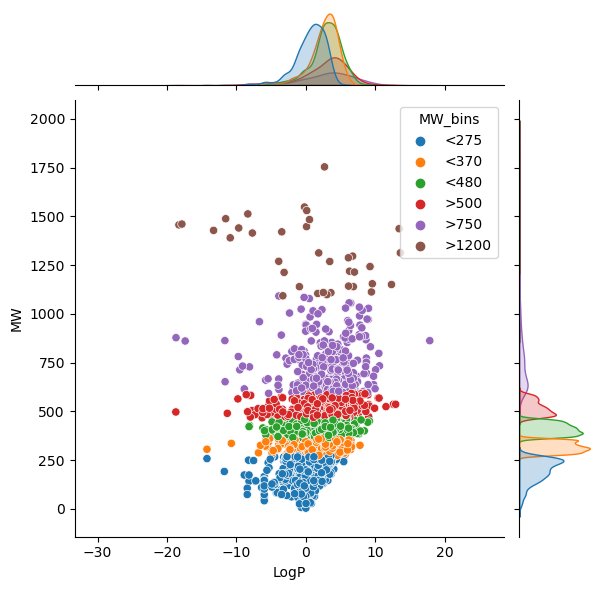

In [14]:
sns.jointplot(x=data.LogP,y=data.MW,kind='scatter',hue=data.MW_bins)
plt.show()

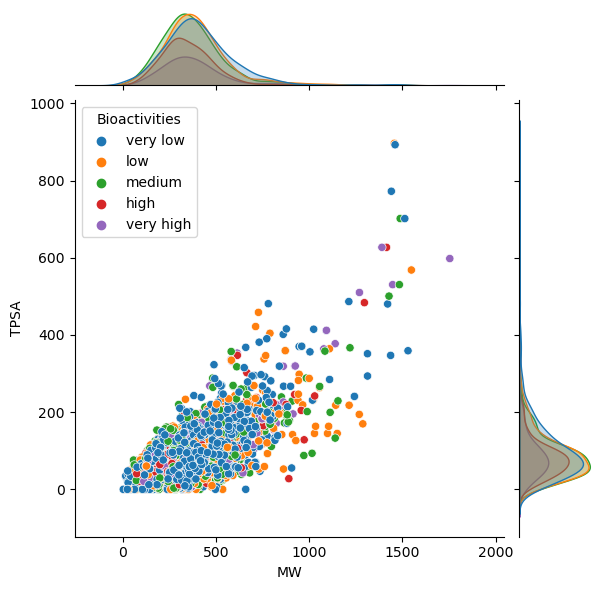

In [105]:
sns.jointplot(x=df.MW,y=df.TPSA,kind='scatter',hue=df.Bioactivities)
plt.show()

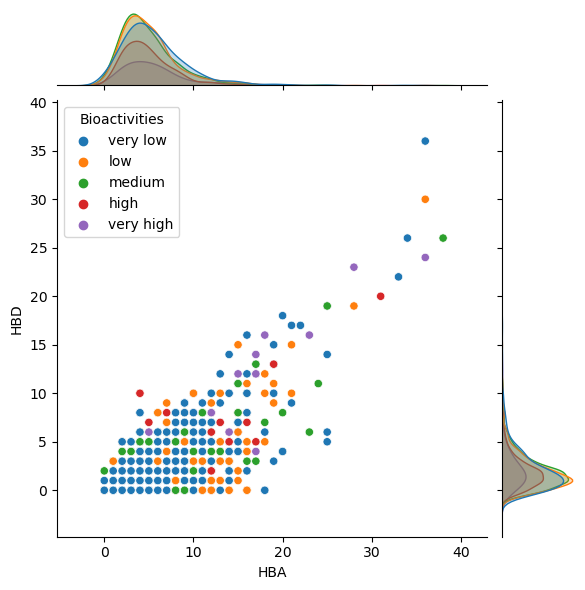

In [106]:
sns.jointplot(x=df.HBA,y=df.HBD,kind='scatter',hue=df.Bioactivities)
plt.show()

In [16]:
#Explore some atom groups that might be relevant for compound properties
patterns=['N','C','F','O','Cl','Br','P','S']

for pattern in patterns:
    data[f"Num_{pattern}"]=data.RMolH.apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(pattern))))

print(data.head())


       ChEMBL ID                Name  \
0   CHEMBL590799            CAMOSTAT   
1  CHEMBL1200675  TOREMIFENE CITRATE   
2   CHEMBL258405             ICILLIN   
3  CHEMBL1200436         OXANDROLONE   
4   CHEMBL506871           VELIPARIB   

                                              Smiles  \
0  CN(C)C(=O)COC(=O)Cc1ccc(OC(=O)c2ccc(NC(=N)N)cc...   
1  CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc...   
2       O=C1NC(c2cccc([N+](=O)[O-])c2)=CCN1c1ccccc1O   
3  C[C@]12COC(=O)C[C@@H]1CC[C@@H]1[C@@H]2CC[C@@]2...   
4              C[C@]1(c2nc3cccc(C(N)=O)c3[nH]2)CCCN1   

                                                RMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001E4674...   
1  <rdkit.Chem.rdchem.Mol object at 0x000001E4674...   
2  <rdkit.Chem.rdchem.Mol object at 0x000001E4674...   
3  <rdkit.Chem.rdchem.Mol object at 0x000001E4674...   
4  <rdkit.Chem.rdchem.Mol object at 0x000001E4674...   

                                               RMolH          MW    TPSA  \
0  <rdkit

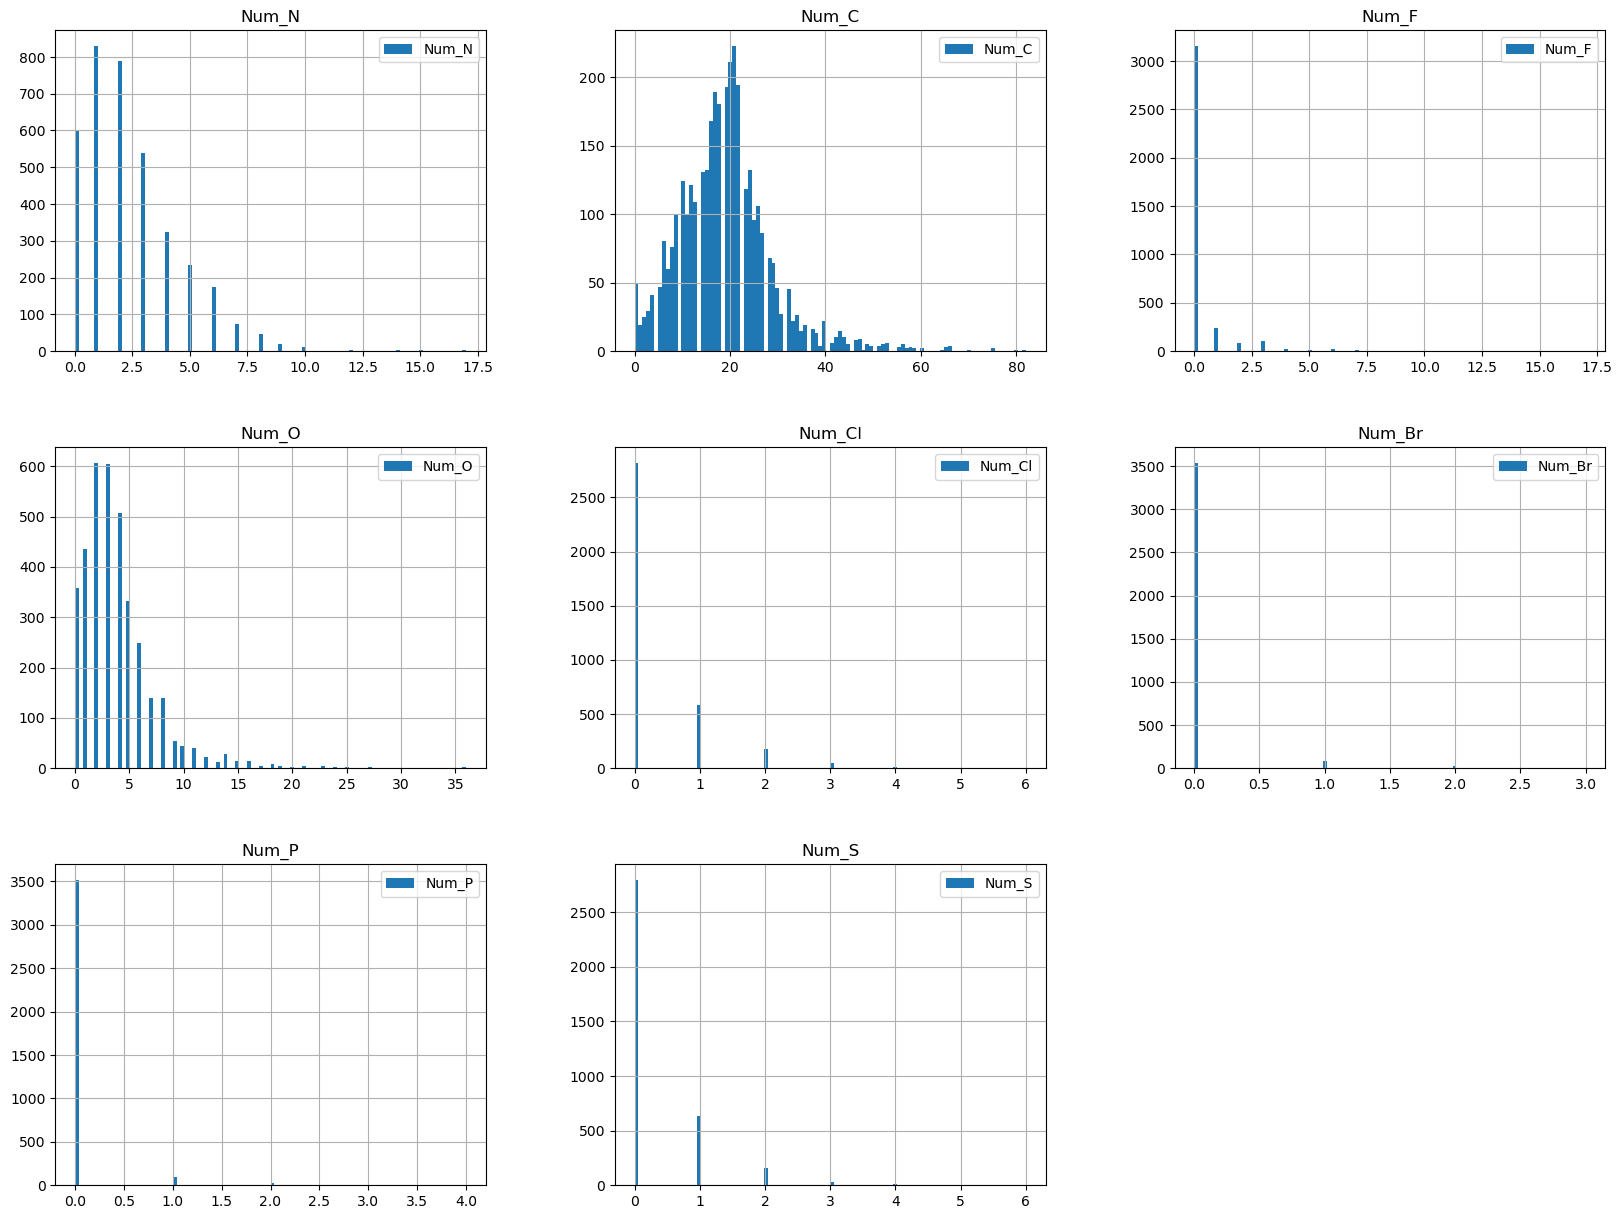

In [17]:
#Explore atom distributions

data[['Num_N','Num_C','Num_F','Num_O','Num_Cl','Num_Br','Num_P','Num_S']].hist(bins=100,figsize=(20, 15), legend=True)
plt.show()

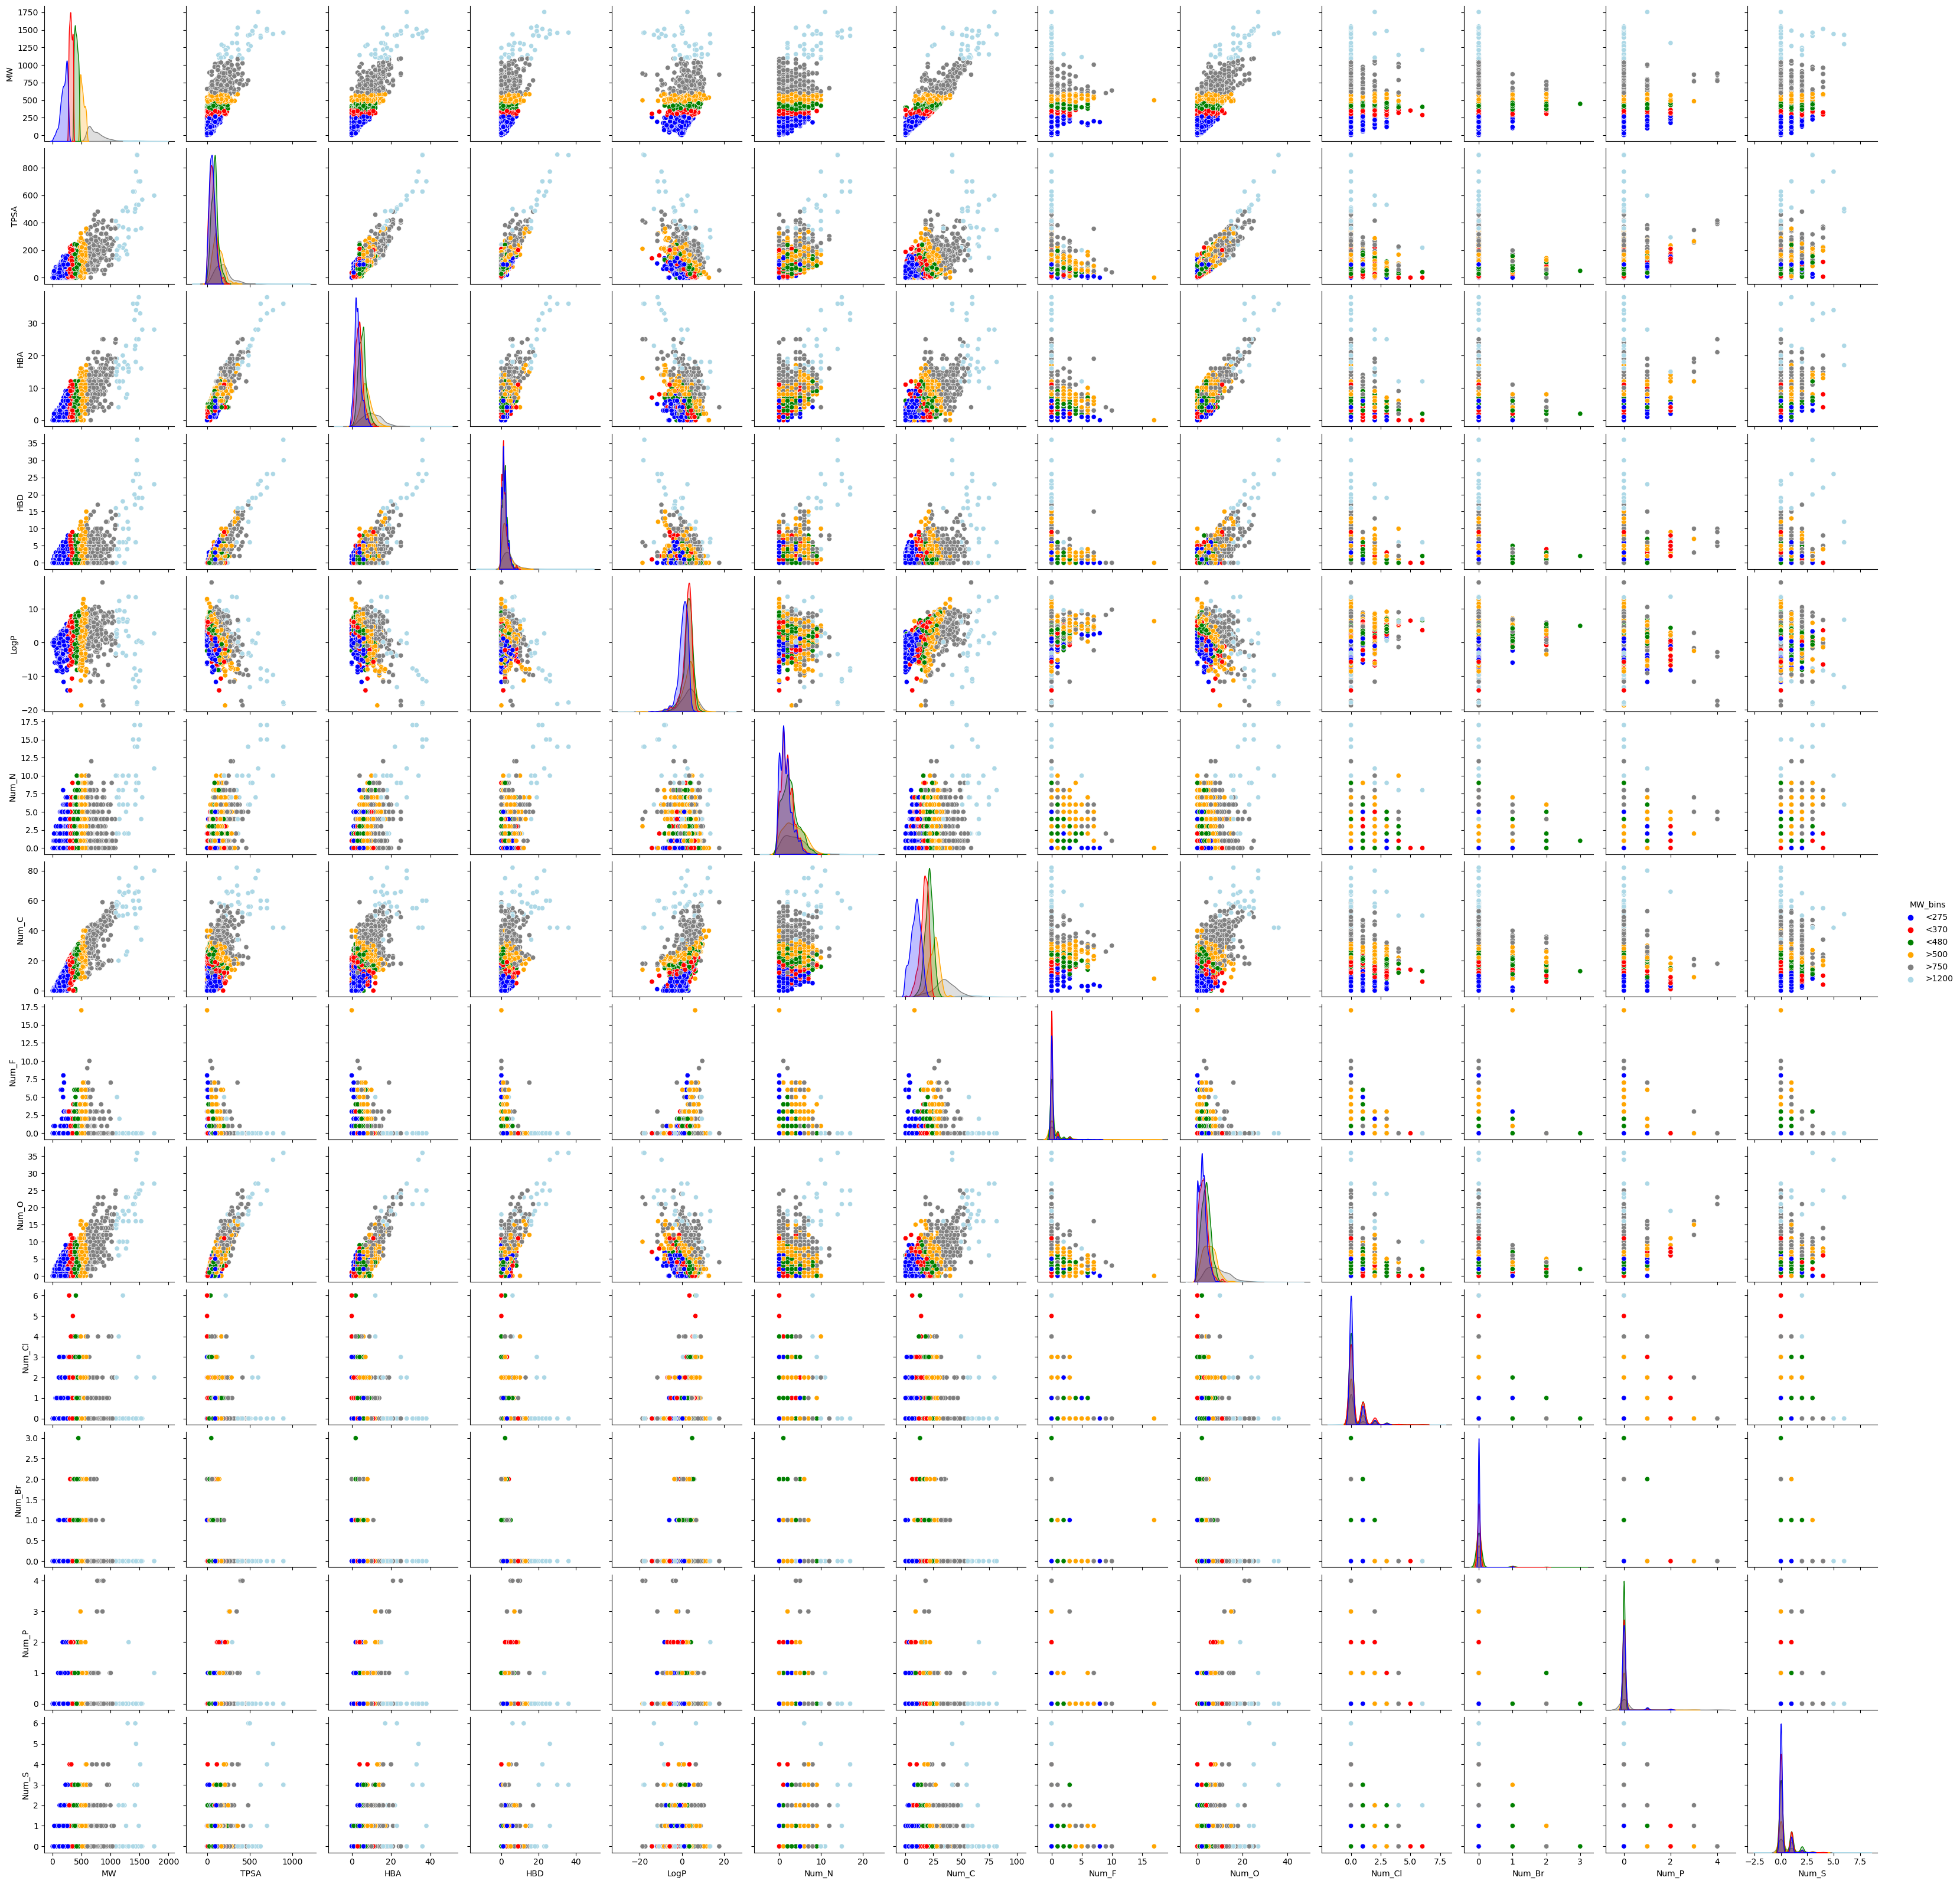

In [18]:
sns.pairplot(data[['MW', 'TPSA', 'HBA', 'HBD', 'LogP','MW_bins','Num_N','Num_C','Num_F','Num_O','Num_Cl','Num_Br','Num_P','Num_S']],hue='MW_bins',diag_kind='kde', palette=['blue','red','green','orange','grey','lightblue'])
plt.show()

### Dimentionality reduction and data exploration

After initial assessment of data features, it is advisable to perform more in-depth analyses. For example, various dimentionality reduction techniques can help identify features or relationships that might not be easily visualised in higher dimensions. Similarly, it helps do decorrelate data or filter unimportant relationships to capture true dependencies.

The following examples explore PCA, kernel PCA and PCA-KMeans as methods to reduce dimensions and perform initial analyses. KMeans can be used as a dimensionality reduction method as well. However, there is no easy way to tell which method would work best. You have to base your evaluation on EDA and various tests on data.

This analytical step will help to further refine your modelling strategies. The following examples will illustrate several approaches that you can employ.


### Physicochemical parameter modelling

In [38]:
#Prepare data for training using compound parameters
#We are going to focus on physicochemical features to predict bioactivities
features=['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP']
X=data[features]
#Encode target values
le=LabelEncoder()
y=le.fit_transform(target_vals.Bioactivities)
mapping=dict(zip(le.transform(le.classes_),le.classes_))
print(mapping) #Check how label encoder encoded your data

#For this example, we will not focus on the test set; however, here we are showing how to split data
#in case you run additional evaluation tests 
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.2,random_state=0)

#Scale data
#For PCA and Kmeans we need to standardize our data
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

{0: 'high', 1: 'low', 2: 'medium', 3: 'very high', 4: 'very low'}


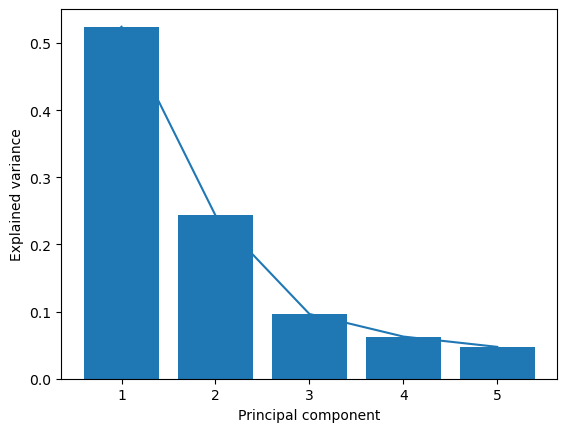

In [49]:
#Transform data features
pca=PCA(0.95)
pca_X_train=pca.fit_transform(X_train)

#Explore variance
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()


In [40]:
label_mapping=[mapping[val] for val in y_train]

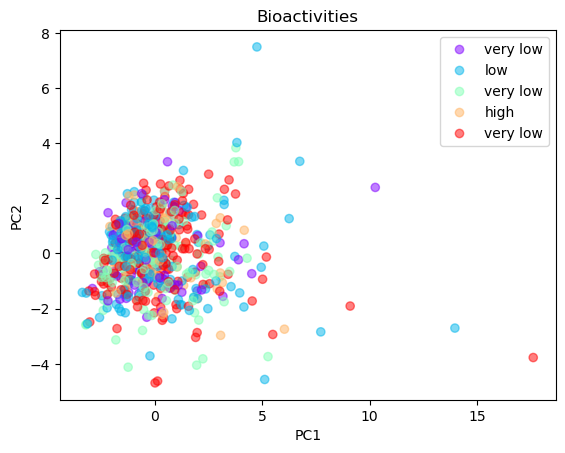

In [50]:

#Plot PCA1 and PCA2

p=plt.scatter(pca_X_train[:,0],pca_X_train[:,1],c=y_train,cmap='rainbow',alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=p.legend_elements()[0],labels=label_mapping)
plt.title('Bioactivities')
plt.show()


In [51]:
#Plot PCA1 and PCA2 with feature components
pc_df=pd.DataFrame(pca.components_.T,columns=[f"PC{i}" for i in range(1,pca.n_components_+1)],index=features)
print(pc_df)

                    PC1       PC2       PC3       PC4       PC5
MW             0.451397  0.256622  0.088646 -0.083838  0.443695
TPSA           0.485242 -0.224091 -0.116938 -0.061282  0.046779
AromaticRings  0.191487  0.516151 -0.696741  0.362320 -0.281574
nRB            0.352143  0.246119  0.670347  0.409450 -0.439306
HBA            0.483574 -0.095840 -0.047365  0.094174  0.450987
HBD            0.405442 -0.287770 -0.139556 -0.539266 -0.568675
LogP          -0.043389  0.681869  0.148102 -0.624991  0.043487


In [52]:
df=pca.components_[0:2,:].T
var=pca.explained_variance_ #get eigenvalue

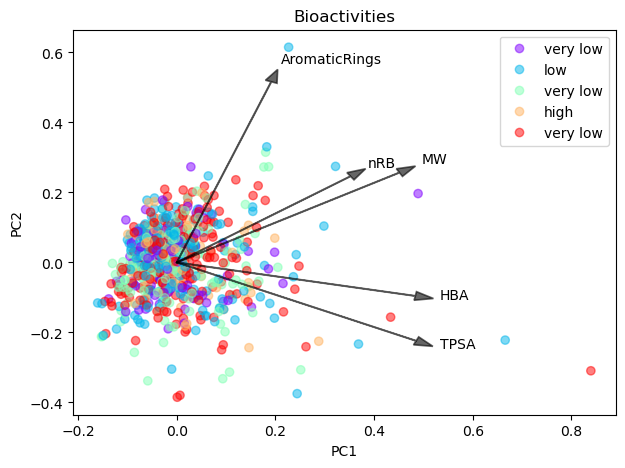

In [54]:
#Plot PCA1 and PCA2 with feature vectors

fig=plt.figure(figsize=(7,5))
#Explore different scaling options
#pca_X_train_scaled=MinMaxScaler(feature_range=(-1,1)).fit_transform(pca_X_train)
#pca_X_train_scaled=StandardScaler().fit_transform(pca_X_train)
scaling=1/(pca_X_train.max(axis=0)-pca_X_train.min(axis=0))
pca_X_train_scaled=pca_X_train*scaling

p=plt.scatter(pca_X_train_scaled[:,0],pca_X_train_scaled[:,1],c=y_train,cmap='rainbow',alpha=0.5)
for i in range(pca.n_components_):
    plt.arrow(0,0,df[i,0],df[i,1],color= 'k',alpha=0.6,linewidth=1.2,head_width=0.025)
    plt.text(df[i,0]*1.1,df[i,1]*1.1,features[i])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=p.legend_elements()[0],labels=label_mapping)
plt.title('Bioactivities')
plt.show()

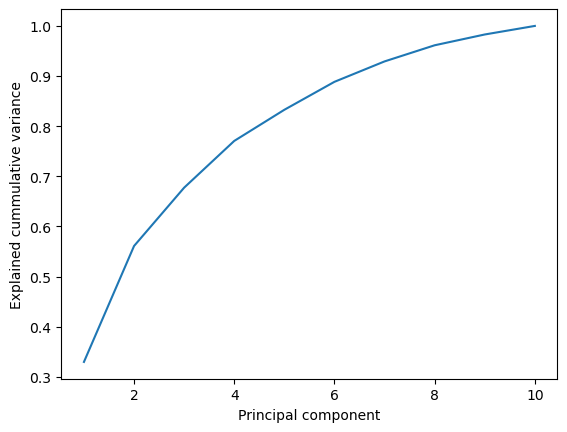

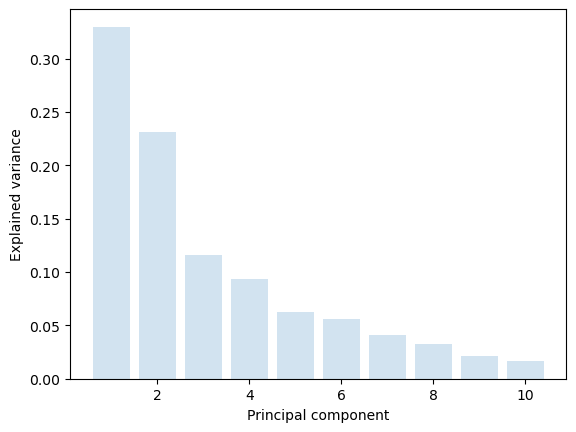

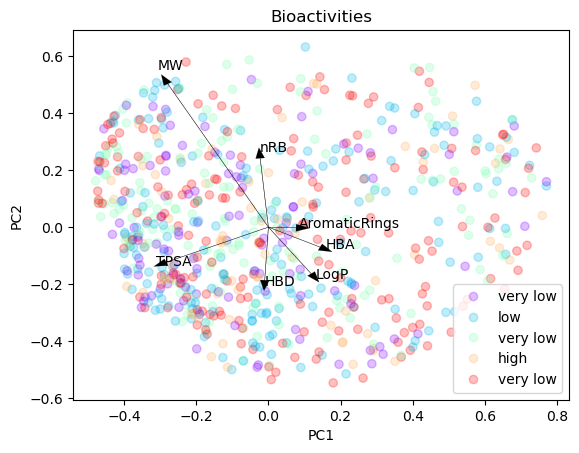

In [55]:
#Transform data features with kernel PCA
#Test various kernels
pca_kernel=KernelPCA(n_components=10,kernel='rbf',gamma=0.05,fit_inverse_transform=True)
pca_X_train=pca_kernel.fit_transform(X_train)

#Explore variance
var=[i/sum(pca_kernel.eigenvalues_) for i in pca_kernel.eigenvalues_]
plt.plot(range(1,len(var)+1),np.cumsum(var))
plt.xlabel('Principal component')
plt.ylabel('Explained cummulative variance')
plt.show()
plt.bar(range(1,len(var)+1),var,alpha=0.2)
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()
#Scale data
scaling=1/(pca_X_train.max(axis=0)-pca_X_train.min(axis=0))
pca_X_train_scaled=pca_X_train*scaling
eigenvectors=pca_kernel.X_transformed_fit_[0:2,].T

#Plot PCA1 and PCA2

p=plt.scatter(pca_X_train[:,0],pca_X_train[:,1],c=y_train,cmap='rainbow',alpha=0.25)

for i in range(len(features)):
    plt.arrow(0,0,eigenvectors[i,0],eigenvectors[i,1],color= 'black',linewidth=0.1,head_width=0.025)
    plt.text(eigenvectors[i,0]*1.1,eigenvectors[i,1]*1.1,features[i])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=p.legend_elements()[0],labels=label_mapping)
plt.title('Bioactivities')
plt.show()


In [56]:
#Kmeans analysis on linear transform
pca=PCA(0.95)
pca_X_train=pca.fit_transform(X_train)
#Capture PC1 and PC2 that will later be used for clustering
df=pd.DataFrame(pca_X_train[:,[0,1]],columns=["PC1","PC2"])

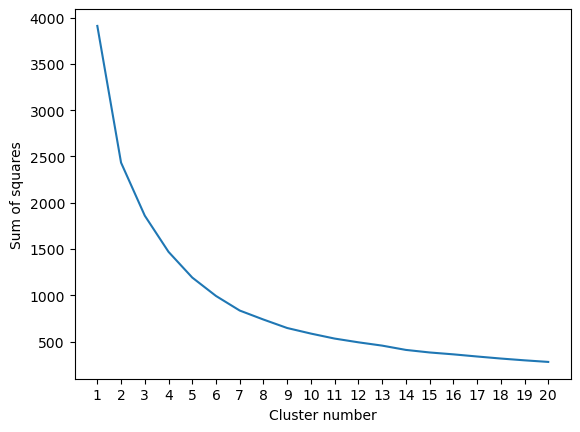

In [19]:
#Test optimal numper of clusters
wcss=[]
for i in range(1,21):
    kmean_i=KMeans(n_clusters=i)
    kmean_i.fit(df)
    wcss+=[kmean_i.inertia_]

plt.plot(list(range(1,21)),wcss)
plt.xticks(np.arange(1,21,1))
plt.xlabel('Cluster number')
plt.ylabel('Sum of squares')
plt.show()

In [57]:
#Using elbow method select clustern number 7
kmeans=KMeans(n_clusters=7)
y_pred=kmeans.fit_predict(df)

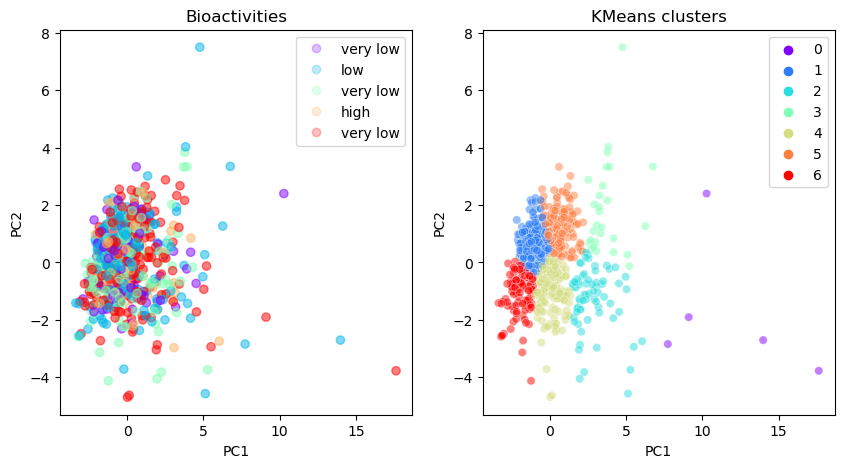

In [62]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax.flatten()
ax[0].scatter(df['PC1'],df['PC2'],c=y_train,cmap='rainbow',alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].legend(handles=p.legend_elements()[0],labels=label_mapping)
ax[0].set_title('Bioactivities')
sns.scatterplot(df,x='PC1',y='PC2',hue=y_pred,palette='rainbow',ax=ax[1],alpha=0.5)
ax[1].set_title('KMeans clusters')
plt.show()

In [63]:
#Kmeans analysis on RBF transform
pca_kernel=KernelPCA(n_components=10,kernel='rbf',degree=1,gamma=0.05,fit_inverse_transform=True)
pca_X_train=pca_kernel.fit_transform(X_train)
df=pd.DataFrame(pca_X_train[:,[0,1]],columns=["PC1","PC2"])


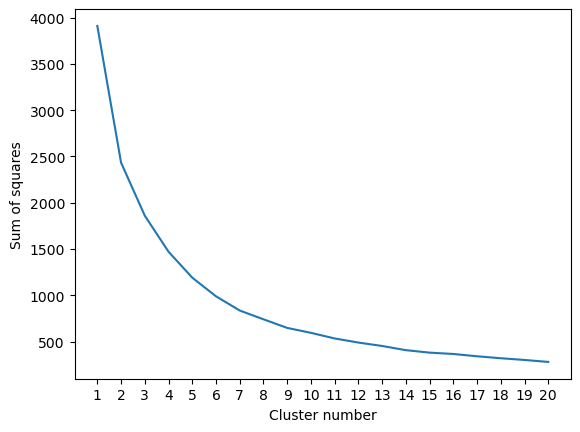

In [126]:
#Test optimal numper of clusters
wcss=[]
for i in range(1,21):
    kmean_i=KMeans(n_clusters=i)
    kmean_i.fit(df)
    wcss+=[kmean_i.inertia_]

plt.plot(list(range(1,21)),wcss)
plt.xticks(np.arange(1,21,1))
plt.xlabel('Cluster number')
plt.ylabel('Sum of squares')
plt.show()

In [64]:
kmeans=KMeans(n_clusters=7)
y_pred=kmeans.fit_predict(df)


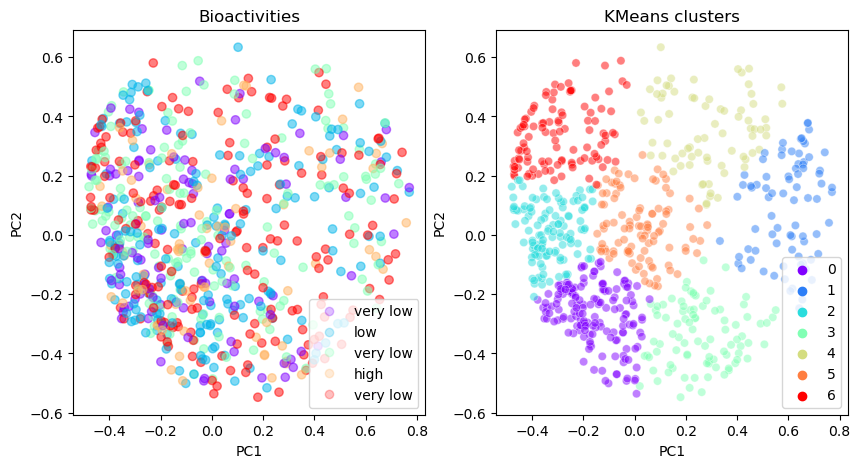

In [65]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax.flatten()
ax[0].scatter(df['PC1'],df['PC2'],c=y_train,cmap='rainbow',alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].legend(handles=p.legend_elements()[0],labels=label_mapping)
ax[0].set_title('Bioactivities')
sns.scatterplot(df,x='PC1',y='PC2',hue=y_pred,palette='rainbow',ax=ax[1],alpha=0.5)
ax[1].set_title('KMeans clusters')
plt.show()

### Structural feature exploration

In contrast to analysing physicochemical properties, we are going to focus on chemical features of each molecule.

In [66]:
#Add fingerprint infomration
data['MorganFP']=data.RMol.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x,radius=3,nBits=128)) #H is not important for a similarity structure search

In [28]:
#Create a heatmap for similarities

similarity_matrix=np.zeros((len(data),len(data)))

for i in range(len(data)):
    for j in range(len(data)):
        similarity_matrix[i,j]=DataStructs.TanimotoSimilarity(data["MorganFP"][i],data["MorganFP"][j])

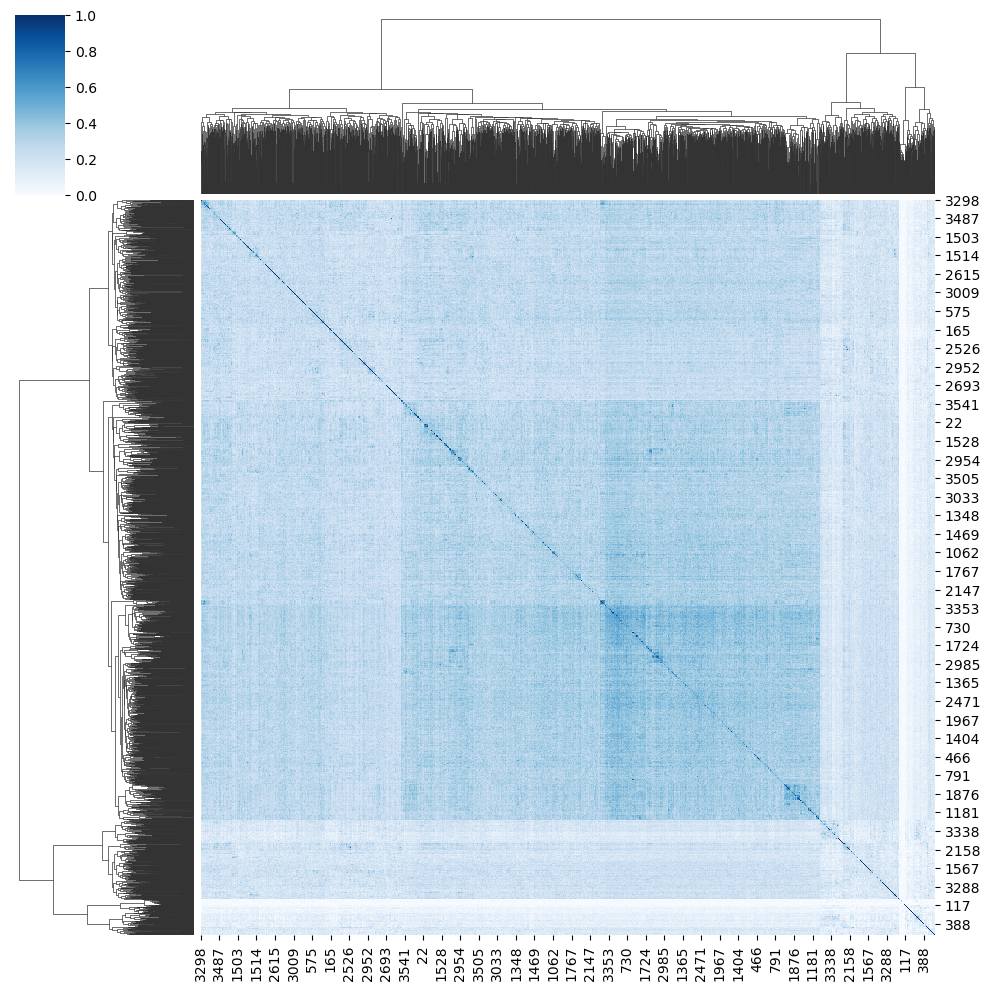

In [29]:
#Plot similarity matrix
sns.clustermap(similarity_matrix,fmt='g',cmap='Blues')
plt.show()

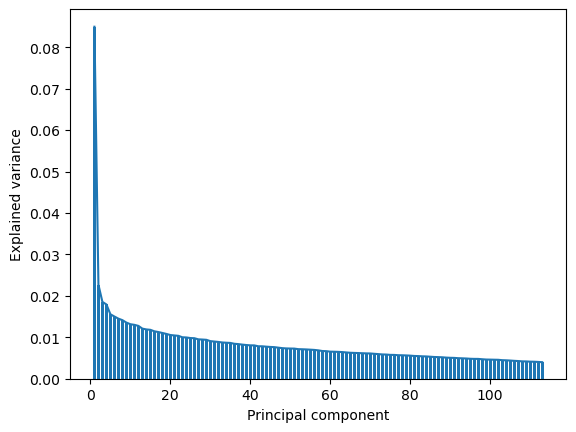

In [67]:
#Explore if clusters emerge in lower dimentions
#NOTE we are using the full dataset in this example
matrix=[np.array(i) for i in data['MorganFP']]
pca=PCA(0.95)
fpt_pca=pca.fit_transform(matrix)
#Explore variance
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()



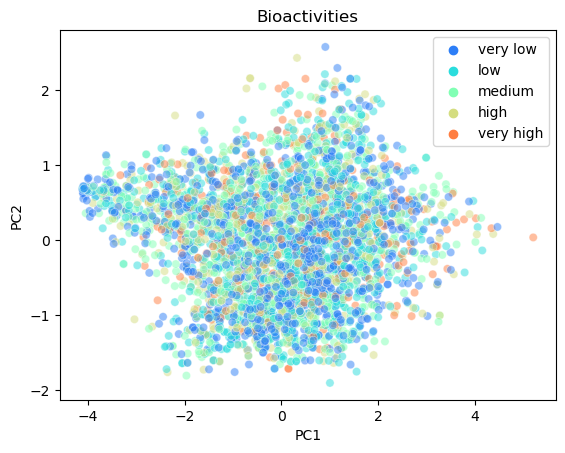

In [69]:
df=pd.DataFrame(fpt_pca[:,[0,1]],columns=["PC1","PC2"])

sns.scatterplot(df,x="PC1",y="PC2",palette='rainbow',hue=target_vals.Bioactivities,alpha=0.5)
plt.legend()
plt.title('Bioactivities')
plt.show()

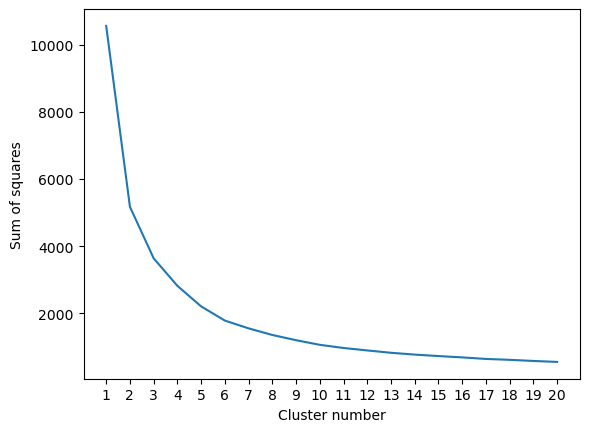

In [48]:

wcss=[]
for i in range(1,21):
    kmean_i=KMeans(n_clusters=i)
    kmean_i.fit(df)
    wcss+=[kmean_i.inertia_]

plt.plot(list(range(1,21)),wcss)
plt.xticks(np.arange(1,21,1))
plt.xlabel('Cluster number')
plt.ylabel('Sum of squares')
plt.show()

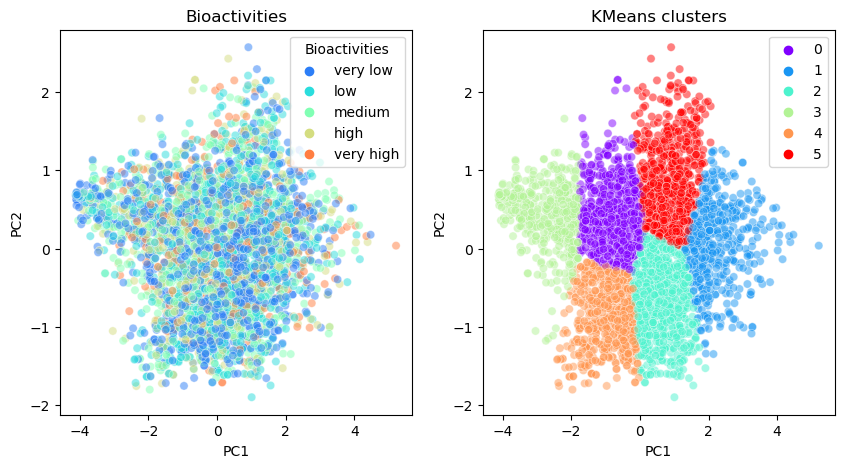

In [70]:
#Kmeans

kmeans=KMeans(n_clusters=6)

y_pred=kmeans.fit_predict(df)

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax.flatten()
sns.scatterplot(df,x='PC1',y='PC2',hue=target_vals.Bioactivities,palette='rainbow',ax=ax[0],alpha=0.5)
sns.scatterplot(df,x='PC1',y='PC2',hue=y_pred,palette='rainbow',ax=ax[1],alpha=0.5)
ax[0].set_title('Bioactivities')
ax[1].set_title('KMeans clusters')
plt.show()

In [71]:
#Explore kernels
pca_kernel=KernelPCA(n_components=10,kernel='poly',degree=5,gamma=0.01)
fpt_pca=pca_kernel.fit_transform(matrix)

#We can see that structural features capture differences in weight distribution
df=pd.DataFrame(fpt_pca[:,[0,1]],columns=["PC1","PC2"])



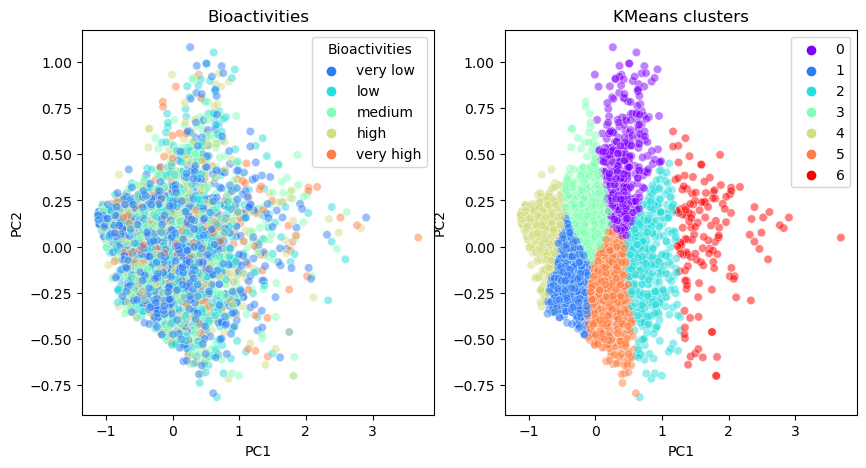

In [72]:
#Kmeans

kmeans=KMeans(n_clusters=7)

y_pred=kmeans.fit_predict(df)

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax.flatten()
sns.scatterplot(df,x='PC1',y='PC2',hue=target_vals.Bioactivities,palette='rainbow',ax=ax[0],alpha=0.5)
sns.scatterplot(df,x='PC1',y='PC2',hue=y_pred,palette='rainbow',ax=ax[1],alpha=0.5)
ax[0].set_title('Bioactivities')
ax[1].set_title('KMeans clusters')
plt.show()

Such EDA helps to perform initial evaluation of your data. For example, we can notice that neither physicochemical nor structural features have predominating variance contributions that would allow data separation. This observation can inform next analytical steps since compound bioactivities are likely dependent on complex feature interactions. In addition, PCA-KMeans can be used to further explore smaller subclusters and patterns.

For classical ML, such an iterative analytical approach can facilitate feature engineering. Similarly, we can evaluate if any additional parameters might be needed to better hypothesize about bioactivities.

Please _NOTE_ that this example illustrates well how real world data can be quite complex and we would likely need additional information and feedback loop based analyses to begin outlining our hypothesis space.